In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
import matplotlib.pyplot as plt
set_seed(3407)

/home/edu/Desktop/nlpt/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input = "Michelle Jones was a top-notch student. Michelle"
print("Input:", input)
bpe = BPETokenizer()
# bpe() gets a string and returns a 2D batch tensor 
# of indices with shape (1, input_length)
tokens = bpe(input)[0]
print("Tokenized input:", tokens)
input_length = tokens.shape[-1]
print("Number of input tokens:", input_length)
# bpe.decode gets a 1D tensor (list of indices) and returns a string
print("Detokenized input from indices:", bpe.decode(tokens))  
tokens_str = []
for token in tokens:
    decoded_token = bpe.decode(torch.tensor([token]))
    tokens_str.append(decoded_token)
print("Detokenized input as strings: " + '/'.join(tokens_str))


Input: Michelle Jones was a top-notch student. Michelle
Tokenized input: tensor([48736,  5437,   373,   257,  1353,    12,  1662,   354,  3710,    13,
        16738])
Number of input tokens: 11
Detokenized input from indices: Michelle Jones was a top-notch student. Michelle
Detokenized input as strings: Michelle/ Jones/ was/ a/ top/-/not/ch/ student/./ Michelle


# Activation patching

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
import torch
from torch.nn import functional as F

In [4]:
# Load model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT.from_pretrained('gpt2').to(device)
tokenizer = BPETokenizer()

number of parameters: 124.44M


In [5]:
# Define clean and corrupted inputs
clean_text = "Michelle Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Michelle"

In [6]:
# Tokenize texts
clean_tokens = tokenizer(clean_text)[0]
corrupted_tokens = tokenizer(corrupted_text)[0]
assert clean_tokens.shape == corrupted_tokens.shape, "Tokens must have the same shape"
print("Number of tokens:", clean_tokens.shape[0])

Number of tokens: 11


In [7]:
# Generate from clean text
output = model.generate(clean_tokens.unsqueeze(0).to(device), max_new_tokens=1, do_sample=False)
print("Output from clean text:", tokenizer.decode(output[0].cpu()))

Output from clean text: Michelle Jones was a top-notch student. Michelle Jones


In [8]:
# Tokenize the clean text
clean_tokens = tokenizer(clean_text)[0].unsqueeze(0).to(device)

# Pass it through the model via the generate function
output = model.generate(clean_tokens, max_new_tokens=1, do_sample=False)

# Display the most probable continuations based on the logits of the last token
logits = model.activations[-1][0, -1]
probs = F.softmax(logits, dim=-1)
top_probs, top_indices = torch.topk(probs, k=20, dim=-1)
top_tokens = [tokenizer.decode(torch.tensor([idx])) for idx in top_indices]

print("Top 20 tokens at last position:")
for prob, token in zip(top_probs, top_tokens):
    print(f"{token}: {prob.item()}")

Top 20 tokens at last position:
 will: 0.9999101161956787
�: 8.986398461274803e-05
age: 2.9531110709403215e-33
ra: 7.882418566514192e-36
 w: 5.100726410142334e-43
�: 2.942726775082116e-44
�: 2.6624670822171524e-44
 d: 2.802596928649634e-45
's: 1.401298464324817e-45
ove: 1.401298464324817e-45
ous: 0.0
 K: 0.0
ated: 0.0
 us: 0.0
 3: 0.0
 ad: 0.0
 their: 0.0
 up: 0.0
.": 0.0
per: 0.0


In [9]:
# Copy the activations of the clean text
clean_activations = [activation.clone().detach() for activation in model.activations]
print(len(clean_activations))
print(clean_activations[0].shape)

12
torch.Size([1, 11, 768])


In [10]:
# Get the indices of the " Smith" and " Jones" tokens
smith_index = tokenizer(" Smith")[0].item()
jones_index = tokenizer(" Jones")[0].item()

print("Smith index:", smith_index)
print("Jones index:", jones_index)

Smith index: 4176
Jones index: 5437


In [11]:
# Initialize matrix to store logit differences
logit_diff_matrix = torch.zeros((12, len(corrupted_tokens)))

# Iterate through layers and token positions
for layer in range(12):
    for pos in range(len(corrupted_tokens)):
        embedding_to_patch = clean_activations[layer][0, pos].clone()

        # Generate output with the corrupted text making patches in layer, pos
        logits, _ = model.forward(corrupted_tokens.unsqueeze(0).to(device), patch_embedding={
            "layer": layer,
            "position": pos,
            "embedding": embedding_to_patch
        })

        # Compute logits for the last token
        logits = model.last_token_logits
        
        # Calculate logit difference between ' Smith' and ' Jones'
        logit_diff = logits[0, smith_index] - logits[0, jones_index]

        # Store logit difference in the matrix
        logit_diff_matrix[layer, pos] = logit_diff.item()

# Print the logit difference matrix
print("Logit Difference Matrix:")
print(logit_diff_matrix)

Logit Difference Matrix:
tensor([[ 5.4126, -5.1408,  5.3547,  5.0155,  5.8312,  3.4290,  5.2722,  5.7073,
          7.0070,  3.4531,  5.3699],
        [ 5.0470, -1.5990,  6.2748,  3.9999,  3.3441,  4.8953,  7.1912,  5.4378,
          5.4092,  6.3438,  3.9422],
        [ 5.9883, -4.7199,  5.5782,  6.3342,  4.9138,  5.2971,  5.3257,  6.6784,
          5.6257,  5.2687,  5.3375],
        [ 4.4128, -2.4018,  3.2691,  5.4178,  3.1267,  5.1900,  4.7085,  4.7206,
          4.1689,  5.6851,  4.8603],
        [ 6.3000, -4.6814,  5.7367,  5.9305,  6.1876,  5.3827,  5.4690,  5.7748,
          3.3296,  3.8568,  3.6811],
        [ 4.3464, -3.5710,  5.3922,  4.3116,  5.2643,  5.5301,  5.3341,  5.4320,
          4.1603,  3.2764,  3.8564],
        [ 3.9005, -4.5052,  6.2134,  4.2122,  7.3958,  6.0431,  4.9973,  6.4587,
          5.2205,  6.9573,  4.7027],
        [ 6.7845, -4.6783,  6.3093,  2.6051,  5.1674,  5.0001,  5.1368,  4.6370,
          6.1161,  5.3923,  3.6793],
        [ 5.4645, -0.7517,  4.6

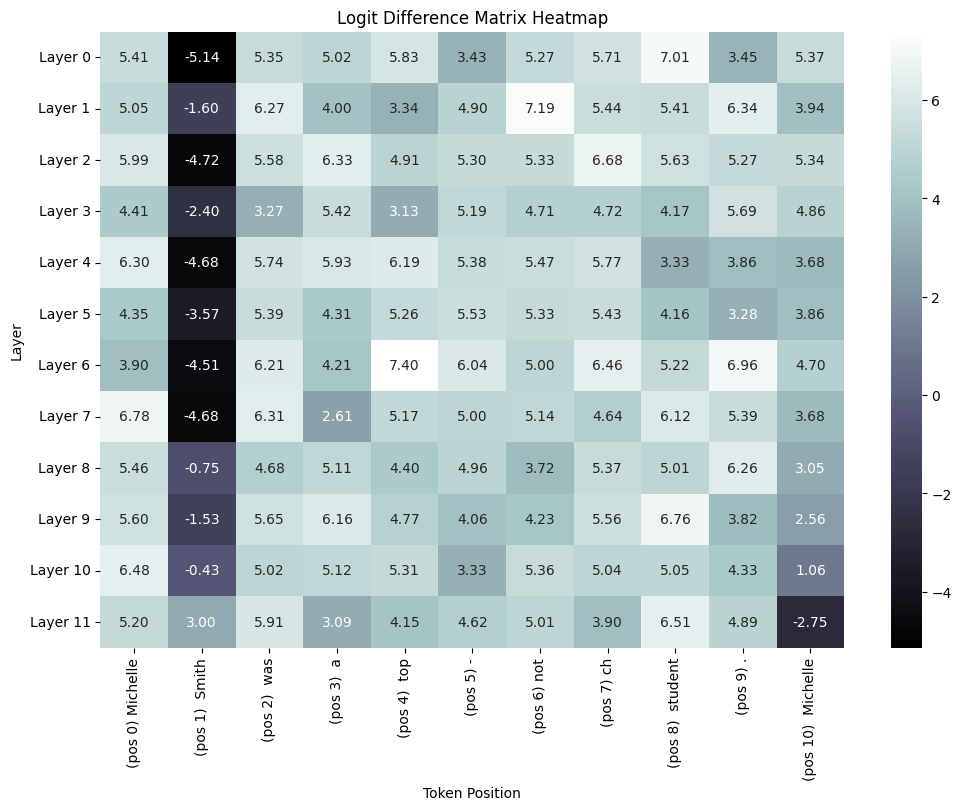

In [12]:
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(logit_diff_matrix.cpu().numpy(), cmap="bone", annot=True, fmt=".2f",
            xticklabels=[f"(pos {i}) {tokenizer.decode(torch.tensor([corrupted_tokens[i]]))}" for i in range(logit_diff_matrix.shape[1])],
            yticklabels=[f"Layer {i}" for i in range(logit_diff_matrix.shape[0])])
plt.title("Logit Difference Matrix Heatmap")
plt.xlabel("Token Position")
plt.ylabel("Layer")
plt.show()

In [64]:
# Function to do the test with 2 new texts
def test(model, clean_text, corrupted_text, token1, token2):
    # Tokenize texts
    clean_tokens = tokenizer(clean_text)[0]
    corrupted_tokens = tokenizer(corrupted_text)[0]
    assert clean_tokens.shape == corrupted_tokens.shape, "Tokens must have the same shape"
    print("Clean tokens shape: ", clean_tokens.shape)
    print("Corrupted tokens shape: ", corrupted_tokens.shape)
    print("Number of tokens:", clean_tokens.shape[0])

    # Generate from clean text
    clean_tokens = clean_tokens.unsqueeze(0).to(device)
    output = model.generate(clean_tokens, max_new_tokens=1, do_sample=False)
    print("Output from clean text:", tokenizer.decode(output[0].cpu()))

    # Copy the activations of the clean text
    clean_activations = [activation.clone().detach() for activation in model.activations]
    clean_logits = model.last_token_logits.clone().detach()

    # Generate from corrupted text
    output = model.generate(corrupted_tokens.unsqueeze(0).to(device), max_new_tokens=1, do_sample=False)
    print("Output from corrupted text:", tokenizer.decode(output[0].cpu()))

    

    # Get the indices of the token1 and token2 tokens
    token1_index = tokenizer(token1)[0].item()
    token2_index = tokenizer(token2)[0].item()
    print(f"{token1} index:", token1_index)
    print(f"{token2} index:", token2_index)


    # Initialize matrix to store logit differences
    logit_diff_matrix = torch.zeros((12, len(corrupted_tokens)))

    # Compute the baseline difference between token1 and token2
    
    corrupt_logits = model.last_token_logits
    base_diff = (clean_logits[0, token1_index] - clean_logits[0, token2_index]) - (corrupt_logits[0, token1_index] - corrupt_logits[0, token2_index])
    
    #print(logit_diff_matrix.shape)
    # Iterate through layers and token positions
    for layer in range(12):
        for pos in range(len(corrupted_tokens)):
            logit_diff_matrix[layer,pos] -= base_diff
            embedding_to_patch = clean_activations[layer][0, pos].clone()

            # Generate output with the corrupted text making patches in layer, pos
            logits, _ = model.forward(corrupted_tokens.unsqueeze(0).to(device), patch_embedding={
                "layer": layer,
                "position": pos,
                "embedding": embedding_to_patch
            })

            # Compute logits for the last token
            logits = model.last_token_logits

            # Calculate logit difference between token1 and token2
            logit_diff = logits[0, token1_index] - logits[0, token2_index]

            # Store logit difference in the matrix
            logit_diff_matrix[layer, pos] = logit_diff.item()

    # Plot heatmap
    #print(logit_diff_matrix.shape)
    plt.figure(figsize=(12, 8))
    sns.heatmap(logit_diff_matrix.cpu().numpy(), cmap="bone", annot=True, fmt=".2f",
                xticklabels=[f"(pos {i}) {tokenizer.decode(torch.tensor([corrupted_tokens[i]]))}" for i in range(logit_diff_matrix.shape[1])],
                yticklabels=[f"Layer {i}" for i in range(logit_diff_matrix.shape[0])])
    plt.title("Logit Difference Matrix Heatmap")
    plt.xlabel("Token Position")
    plt.ylabel("Layer")
    plt.show()

Clean tokens shape:  torch.Size([11])
Corrupted tokens shape:  torch.Size([11])
Number of tokens: 11
Output from clean text: Jessica Jones was a top-notch student. Michelle was
Output from corrupted text: Michelle Smith was a top-notch student. Jessica was
 Smith index: 4176
 Jones index: 5437


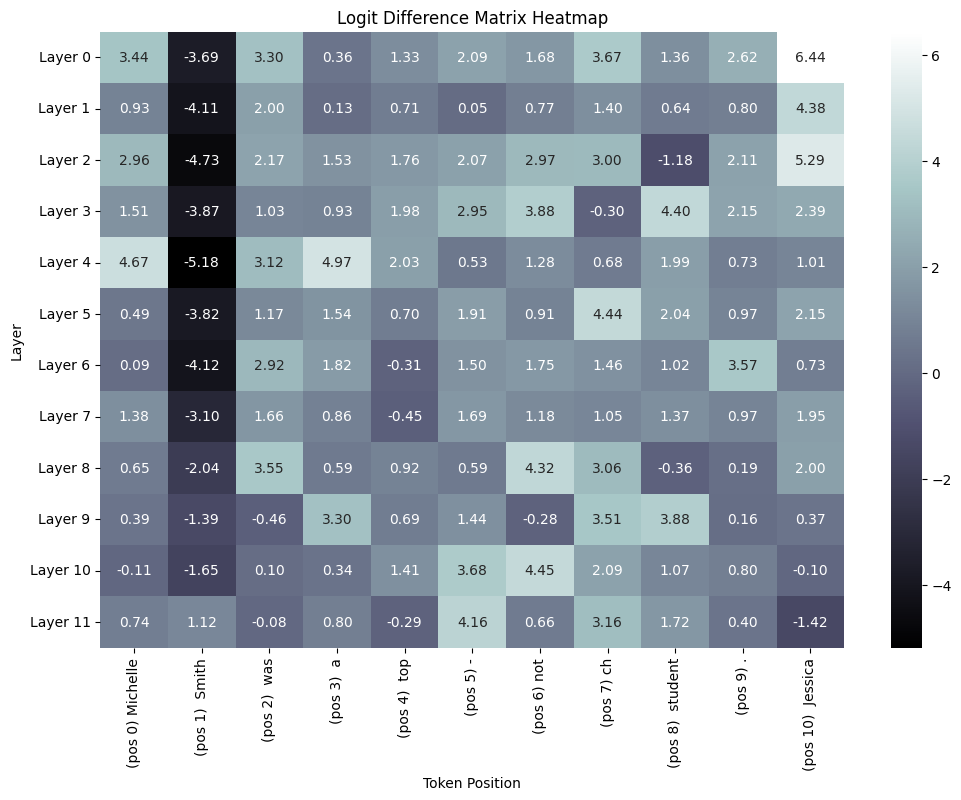

In [65]:
# Clean text
clean_text = "Jessica Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Jessica"

test(model, clean_text, corrupted_text, " Smith", " Jones")


Clean tokens shape:  torch.Size([12])
Corrupted tokens shape:  torch.Size([12])
Number of tokens: 12
Output from clean text: I love the Eiffel Tower and my favourite country is the
Output from corrupted text: I love the Eiffel Tower and my favourite city is London
 Paris index: 6342
 France index: 4881


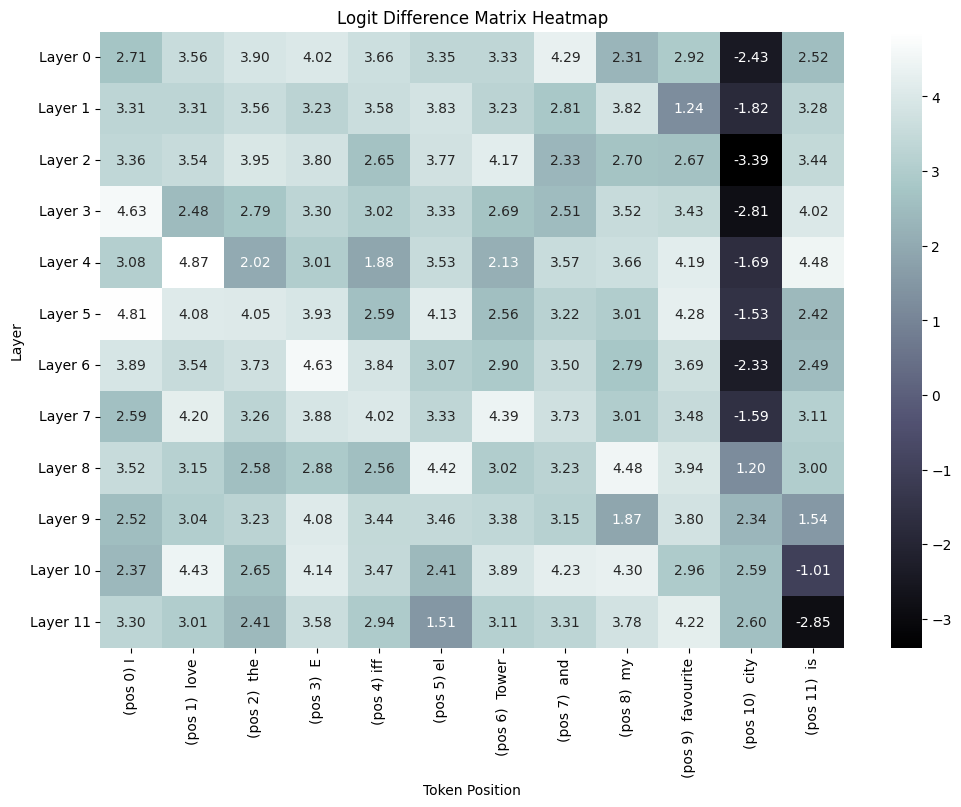

In [66]:
clean_text = "I love the Eiffel Tower and my favourite country is"
corrupted_text = "I love the Eiffel Tower and my favourite city is"

test(model, clean_text, corrupted_text, " Paris", " France")

## Syntactic Role Intervention

Clean tokens shape:  torch.Size([17])
Corrupted tokens shape:  torch.Size([17])
Number of tokens: 17
Output from clean text: The chef who mentored the cooks prepared his special dish. It was very special for me
Output from corrupted text: The chef who mentored the cooks prepared their special dish. It was very special for me
 them index: 606
 him index: 683


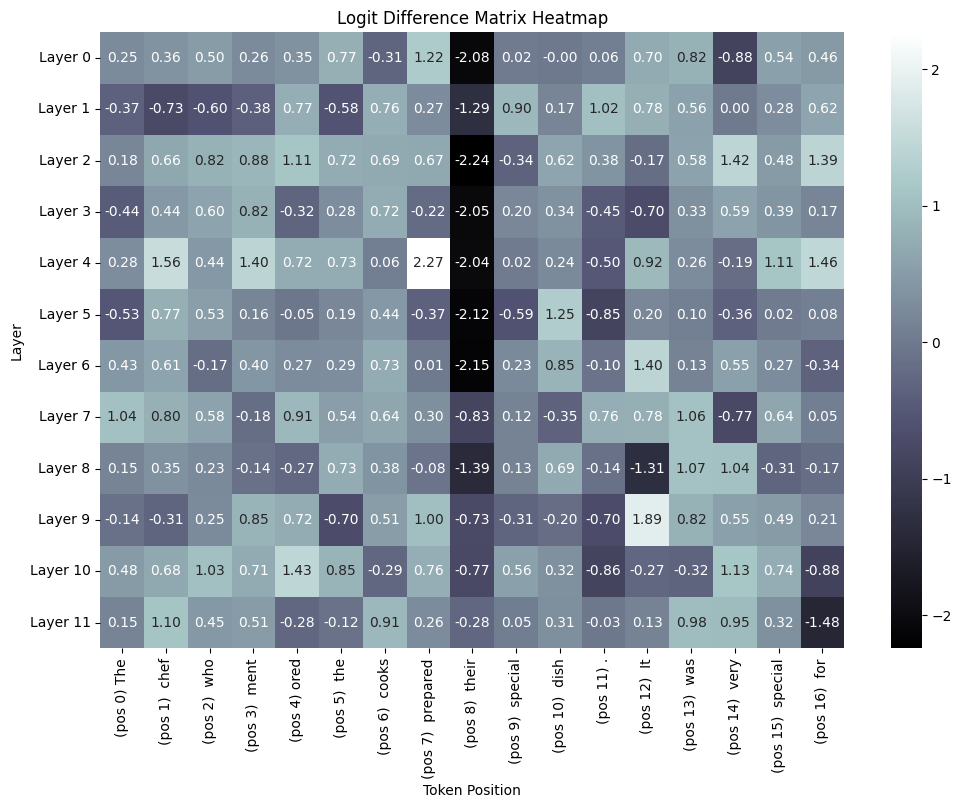

In [67]:
clean_text = "The chef who mentored the cooks prepared his special dish. It was very special for"
corrupted_text = "The chef who mentored the cooks prepared their special dish. It was very special for"

test(model, clean_text, corrupted_text, " them", " him")

Clean tokens shape:  torch.Size([5])
Corrupted tokens shape:  torch.Size([5])
Number of tokens: 5
Output from clean text: The medication causes no serious side
Output from corrupted text: The medication causes very serious damage
 complications index: 19481
 side index: 1735


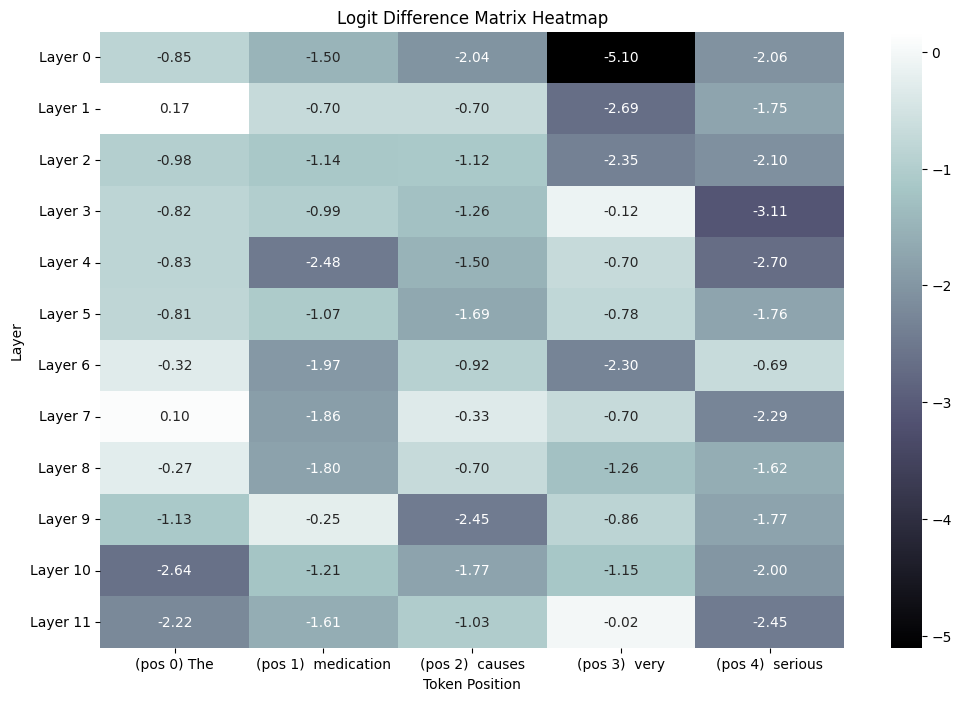

In [68]:
clean_text = "The medication causes no serious"
corrupted_text = "The medication causes very serious"

test(model, clean_text, corrupted_text, " complications", " side")